In [1]:
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import torch.nn as nn

### Data processing

In [3]:
swda = load_dataset("swda")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/213543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/56729 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4514 [00:00<?, ? examples/s]

Dataset swda downloaded and prepared to /root/.cache/huggingface/datasets/swda/default/0.0.0/b53d17ec4c6e31d0921591dd2d8e86d15850822209a980fcddb2983fc948e499. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
swda

DatasetDict({
    train: Dataset({
        features: ['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index', 'act_tag', 'damsl_act_tag', 'caller', 'utterance_index', 'subutterance_index', 'text', 'pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_education', 'to_caller_birth_year', 'to_caller_dialect_area'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index', 'act_tag', 'damsl_act_tag', 'caller', 'utterance_index', 'subutterance_index', 'text', 'pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_educ

In [5]:
import re

def clean_swda_utterance(text):
    """
    This function takes a string of SWDA utterance text and returns a cleaned version of the text.
    """
    # Remove square brackets and anything inside them
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()
    
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    
    # Remove any remaining non-alphanumeric characters except for spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert all letters to lowercase
    text = text.lower()
    
    # Remove any residual spaces
    text = ' '.join(text.split())
    
    return {"text": text}


In [6]:
swda['train']['text'][67445], clean_swda_utterance(swda['train']['text'][67445])

('big time problems ]  /', {'text': 'big time problems'})

In [7]:
swda = swda.map(lambda x : clean_swda_utterance(x['text']))


  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [8]:
# Define the data preprocessing function
def preprocess_data(utterance):
    text = utterance['text']
    speaker = utterance['caller']
    label = utterance['damsl_act_tag']

    return {'text': text, 'speaker': speaker, 'label': label}
# Preprocess the data
swda = swda.map(preprocess_data)

  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

In [9]:
swda

DatasetDict({
    train: Dataset({
        features: ['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index', 'act_tag', 'damsl_act_tag', 'caller', 'utterance_index', 'subutterance_index', 'text', 'pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_education', 'to_caller_birth_year', 'to_caller_dialect_area', 'speaker', 'label'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index', 'act_tag', 'damsl_act_tag', 'caller', 'utterance_index', 'subutterance_index', 'text', 'pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_s

In [10]:
swda.remove_columns(['swda_filename', 'ptb_basename', 'conversation_no', 'transcript_index', 'act_tag', 'damsl_act_tag', 'caller', 'utterance_index', 'subutterance_index','pos', 'trees', 'ptb_treenumbers', 'talk_day', 'length', 'topic_description', 'prompt', 'from_caller', 'from_caller_sex', 'from_caller_education', 'from_caller_birth_year', 'from_caller_dialect_area', 'to_caller', 'to_caller_sex', 'to_caller_education', 'to_caller_birth_year', 'to_caller_dialect_area'])

DatasetDict({
    train: Dataset({
        features: ['text', 'speaker', 'label'],
        num_rows: 213543
    })
    validation: Dataset({
        features: ['text', 'speaker', 'label'],
        num_rows: 56729
    })
    test: Dataset({
        features: ['text', 'speaker', 'label'],
        num_rows: 4514
    })
})

In [11]:
def map_speaker_to_int(data):
    """
    This function maps the speaker information in an example to 0 or 1.
    """
    # Get the caller information from the example
    caller = data["caller"]
    
    # Map the caller to 0 or 1
    if caller == "A":
        data["speaker"] = 0
    elif caller == "B":
        data["speaker"] = 1
    
    return data

In [12]:
swda = swda.map(map_speaker_to_int)

  0%|          | 0/213543 [00:00<?, ?ex/s]

  0%|          | 0/56729 [00:00<?, ?ex/s]

  0%|          | 0/4514 [00:00<?, ?ex/s]

#### Tokenize utterances

In [14]:
#swda = swda.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)

In [15]:
# Tokenize the input and context
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [16]:
import torch
from torch.utils.data import DataLoader, Dataset


class SWDADataset(Dataset):
    def __init__(self, swda, tokenizer, max_seq_length):
        self.swda = swda
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.swda)

    def __getitem__(self, index):
        # Get input text and speaker
        input_text = self.tokenizer.encode_plus(
            self.swda[index]['text'],
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        speaker = self.swda[index]['speaker']
        
        # Get context and speaker
        if index > 0 and self.swda[index]['conversation_no'] == self.swda[index-1]['conversation_no']:
            context = self.swda[index-1]
            prev_speaker = self.swda[index-1]['speaker']
        else:
            context = self.swda[index]
            prev_speaker = self.swda[index]['speaker']
        context = self.tokenizer.encode_plus(
            context['text'],
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )


        # Get label
        label = self.swda[index]['label']
        
        return input_text, context, (prev_speaker, speaker), label


# Create the train loader
train_dataset = SWDADataset(swda['train'], tokenizer, max_seq_length=128)
val_dataset = SWDADataset(swda['validation'], tokenizer, max_seq_length=128)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=128, shuffle=True)

### GRU encoder with speaker

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class RNN(nn.Module):
    def __init__(self, hidden_size,num_speakers, num_classes):
        super(RNN, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.rnn = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True)
        self.speaker_embedding = nn.Embedding(num_speakers,768)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, input_text,speaker_ids, context):
        input_ids = input_text['input_ids'].to(device)
        attention_mask = input_text['attention_mask'].to(device)
        context_ids = context['input_ids'].to(device)
        prev_speakers = speaker_ids[0].to(device)
        speakers = speaker_ids[1].to(device)
        context_mask = context['attention_mask'].to(device)
        
        prev_speaker_embeddings = self.speaker_embedding(prev_speakers)
        speaker_embeddings = self.speaker_embedding(speakers)

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        pooled_output = outputs.pooler_output
        
        pooled_output = pooled_output + speaker_embeddings
        
        context_outputs = self.bert(input_ids=context_ids, attention_mask=context_mask, return_dict=True)
        pooled_context_output = context_outputs.pooler_output
        
        pooled_context_output = pooled_context_output + prev_speaker_embeddings
        
        
        
        output, _ = self.rnn(pooled_output.unsqueeze(1))
        context_output, _ = self.rnn(pooled_context_output.unsqueeze(1))
        output = self.fc1(output)
        output = torch.cat((output.squeeze(1), context_output.squeeze(1)), dim=1)
        output = self.fc2(output)
        return output

# Instantiate the model
model = RNN(hidden_size=256,num_speakers = 2, num_classes=43)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Model training

In [24]:
num_epochs = 10
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i, (input_text, context, speakers, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        input_text = {
            'input_ids': input_text['input_ids'].squeeze(1),
            'attention_mask': input_text['attention_mask'].squeeze(1),
            'token_type_ids': input_text['token_type_ids'].squeeze(1)
        }
        context = {
            'input_ids': context['input_ids'].squeeze(1),
            'attention_mask': context['attention_mask'].squeeze(1),
            'token_type_ids': context['token_type_ids'].squeeze(1)
        }
        labels = labels.to(device)
        output = model(input_text,speakers, context)
        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * input_text["input_ids"].size(0)

        # Compute accuracy for this batch
        predicted_labels = output.argmax(dim=1)
        num_correct = (predicted_labels == labels).sum().item()
        acc = num_correct / len(labels)
        epoch_acc += acc

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    # Compute average loss and accuracy for epoch
    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)


    # Compute validation loss and accuracy
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for input_text, context, speakers, labels in val_loader:
            input_text = {
                'input_ids': input_text['input_ids'].squeeze(1),
                'attention_mask': input_text['attention_mask'].squeeze(1),
                'token_type_ids': input_text['token_type_ids'].squeeze(1)
            }
            context = {
                'input_ids': context['input_ids'].squeeze(1),
                'attention_mask': context['attention_mask'].squeeze(1),
                'token_type_ids': context['token_type_ids'].squeeze(1)
            }
            labels = labels.to(device)
            output = model(input_text, speakers, context)
            loss = criterion(output, labels)
            val_loss += loss.item() * input_text["input_ids"].size(0)

            # Compute accuracy for this batch
            predicted_labels = output.argmax(dim=1)
            num_correct = (predicted_labels == labels).sum().item()
            acc = num_correct / len(labels)
            val_acc += acc

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc /= len(val_loader)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')


KeyboardInterrupt: 

#### Evaluation

In [32]:
import matplotlib.pyplot as plt

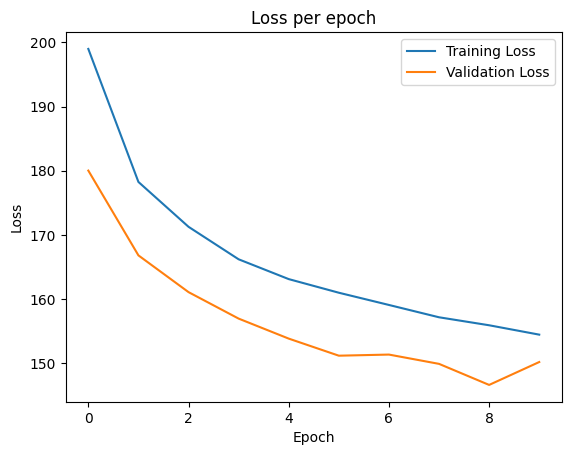

In [44]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()
plt.show()

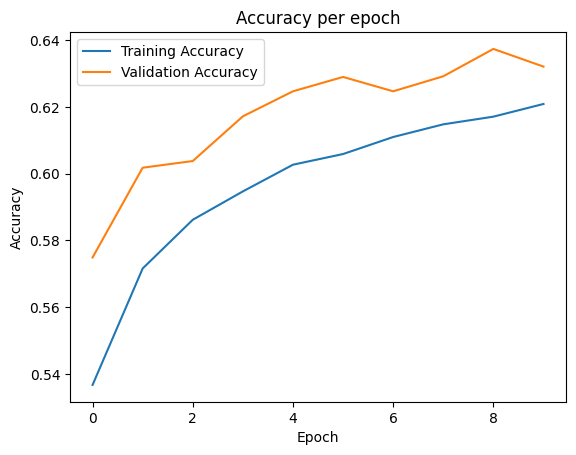

In [39]:
# Plot training and validation accuracies
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()

In [33]:
torch.save(model.state_dict(), 'speaker_context_gru_model.pt')

### Load model

In [20]:
mode_name = '/kaggle/input/grumodel/speaker_context_gru_model.pt'

In [21]:
model_state_dict = torch.load(mode_name, map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)

<All keys matched successfully>

#### Inference

In [18]:
test_dataset = SWDADataset(swda['test'], tokenizer, max_seq_length=128)
test_loader= DataLoader(test_dataset, batch_size=64, shuffle=True)

In [32]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

model.eval()
test_loss = 0
test_acc = 0
all_true_labels = []
all_predicted_labels = []
with torch.no_grad():
    for input_text, context, speakers, labels in test_loader:
        input_text = {'input_ids': input_text['input_ids'].squeeze(1),
                      'attention_mask': input_text['attention_mask'].squeeze(1),
                      'token_type_ids': input_text['token_type_ids'].squeeze(1)
                     }        
        context = {'input_ids': context['input_ids'].squeeze(1),
                   'attention_mask': context['attention_mask'].squeeze(1),
                   'token_type_ids': context['token_type_ids'].squeeze(1)
                  }        
        labels = labels.to(device)        
        output = model(input_text,speakers, context)        
        
        loss = criterion(output, labels)
        test_loss += loss.item() * input_text["input_ids"].size(0)
        predicted_labels = output.argmax(dim=1)
        num_correct = (predicted_labels == labels).sum().item()
        acc = num_correct / len(labels)
        test_acc += acc
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())
test_loss /= len(test_loader)
test_acc /= len(test_loader)

In [33]:
print('test loss: %.3f, test accuracy: %.3f%%' %
      (test_loss, test_acc))

test loss: 77.276, test accuracy: 0.613%


In [56]:
# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted',zero_division=1)
# Create a DataFrame with the metrics
metrics_data = { 'Weighted Avg Precision': [precision],
                'Weighted Avg Recall': [recall],
                'Weighted Avg F1-score': [f1_score]
               }
metrics_df = pd.DataFrame(metrics_data)

# Display the metrics DataFrame
print(metrics_df)

   Weighted Avg Precision  Weighted Avg Recall  Weighted Avg F1-score
0                0.637928             0.612317               0.583538
